In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def DelNoise(contours,value):
    CtoL=list(contours)
    area=np.zeros(len(contours))
    i=0
    while(i<len(CtoL)):
        area[i]=cv2.contourArea(CtoL[i])
        if area[i]<value:
            del CtoL[i]
        else:
            i=i+1
    return CtoL

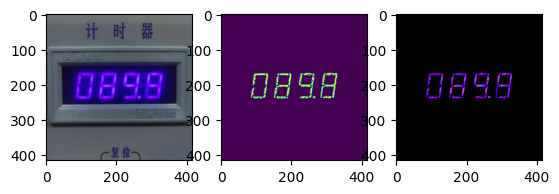

True

In [6]:
img_rgb = cv2.imread("./images/13.jpg")

# Convert the image from BGR to HSV
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2HSV)

# Split the HSV image into its three channels
h, s, v = cv2.split(img_hsv)

# Apply brightness enhancement to the V channel
v_enhanced = np.where(v < 250, 0, 255)

# Convert v_enhanced to the same data type as v
v_enhanced = v_enhanced.astype(v.dtype)

# Merge the enhanced V channel back into the HSV image
enhanced_img_hsv = cv2.merge([h, s, v_enhanced])

# Convert the HSV image back to BGR
enhanced_img_bgr = cv2.cvtColor(enhanced_img_hsv, cv2.COLOR_HSV2BGR)

plt.figure()
plt.subplot(1,3,1)
plt.imshow(img_rgb)
plt.subplot(1,3,2)
plt.imshow(v_enhanced)
plt.subplot(1,3,3)
plt.imshow(enhanced_img_bgr)
plt.show()
cv2.imwrite("./output/enhanced_img_bgr.jpg", enhanced_img_bgr)

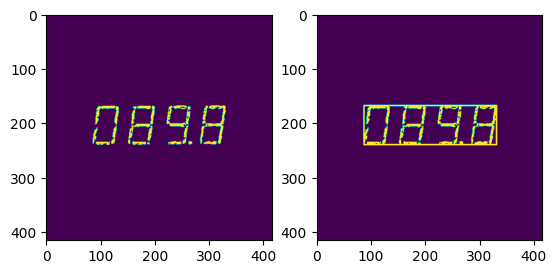

True

In [8]:
# 找到像素值为255的点的坐标
white_pixels = np.where(v_enhanced == 255)
x = white_pixels[1]
y = white_pixels[0]

# 找到外接矩形的左上角坐标，宽度和高度
x_min = np.min(x)
y_min = np.min(y)
x_max = np.max(x)
y_max = np.max(y)

img_with_rect = v_enhanced.copy()

# 在图像上绘制外接矩形
cv2.rectangle(img_with_rect, (x_min, y_min), (x_max, y_max), (255, 255, 255), 2)

# 显示原始图像和绘制了外接矩形的彩色图像
plt.figure()
plt.subplot(1,2,1)
plt.imshow(v_enhanced)
plt.subplot(1,2,2)
plt.imshow(img_with_rect)
plt.show()
cv2.imwrite("./output/img_with_rect.jpg", img_with_rect)

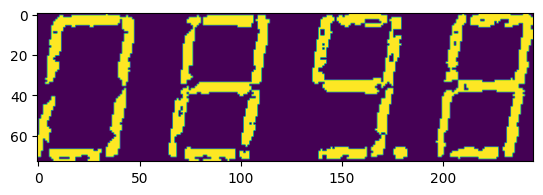

In [9]:
img_roi = v_enhanced[y_min:y_max+1, x_min:x_max+1]
plt.figure()
plt.imshow(img_roi)
plt.show()

15


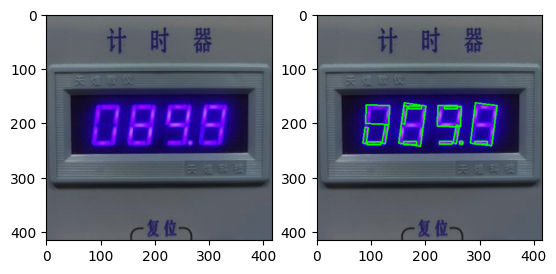

True

In [10]:
# Convert v_enhanced to 8-bit unsigned integer format
v_enhanced = v_enhanced.astype(np.uint8)
# Find contours
contours, _ = cv2.findContours(v_enhanced, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to draw the rectangle on
img_with_rect = img_rgb.copy()

contours=DelNoise(contours,20)
# cv2.drawContours(img_with_rect,tuple(CtoL),-1,(0,255,0),2)
# cvShow('outline',img_with_rect)

print(len(contours))
#Loop through contours and draw minimum enclosing rectangle
for contour in contours:
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img_with_rect, [box], 0, (0, 255, 0), 2)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.subplot(1,2,2)
plt.imshow(img_with_rect)
plt.show()
cv2.imwrite("./output/img_with_rect.jpg", img_with_rect)

In [11]:
v_enhanced.shape

(416, 416)